# Tiling Large Images
- Handle images too large for memory
- Extract patches
- Perform patch-based inference
- Reconstruct heatmaps

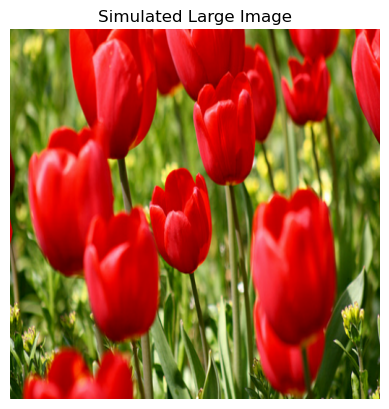

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
import tensorflow_datasets as tfds

TILE_SIZE = 128    # Size of each tile
BATCH_SIZE = 16
NUM_CLASSES = 5    # 5-Flowers dataset

# Load 5-Flowers Dataset

ds_train, ds_val = tfds.load(
    "tf_flowers",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True
)

# Take a sample image and resize to simulate a large image (e.g., 512x512)

for img, label in ds_train.take(1):
    large_image = tf.image.resize(img, [TILE_SIZE*4, TILE_SIZE*4])  # 512x512
    break

plt.imshow(tf.cast(large_image, tf.uint8))
plt.title("Simulated Large Image")
plt.axis("off")
plt.show()


In [5]:
# Tiling Function

def tile_image(image, tile_size=TILE_SIZE):
    """Split a large image into tiles of shape (tile_size, tile_size, 3)"""
    h, w, c = image.shape
    tiles = []
    for i in range(0, h, tile_size):
        for j in range(0, w, tile_size):
            tile = image[i:i+tile_size, j:j+tile_size, :]
            # Pad edges if needed
            tile = tf.image.resize_with_pad(tile, tile_size, tile_size)
            tiles.append(tile)
    return tf.stack(tiles)



In [7]:
# Create Dataset of Tiles

tiles = tile_image(large_image)
print(f"Total tiles: {tiles.shape[0]}")

# Convert to tf.data.Dataset

tiles_ds = tf.data.Dataset.from_tensor_slices((tiles, tf.zeros((tiles.shape[0],), dtype=tf.int32)))
tiles_ds = tiles_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Total tiles: 16


In [8]:
# Build / Load a Model

def build_model(input_shape=(TILE_SIZE, TILE_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=None  # For classroom demo, or set 'imagenet' if available
    )
    base_model.trainable = True

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Instantiate model

model = build_model()

# Optional: Load pretrained weights if available
# model.load_weights("flower_model/")


1/1 [==============================] - 1s 876ms/step
Predicted classes for each tile: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


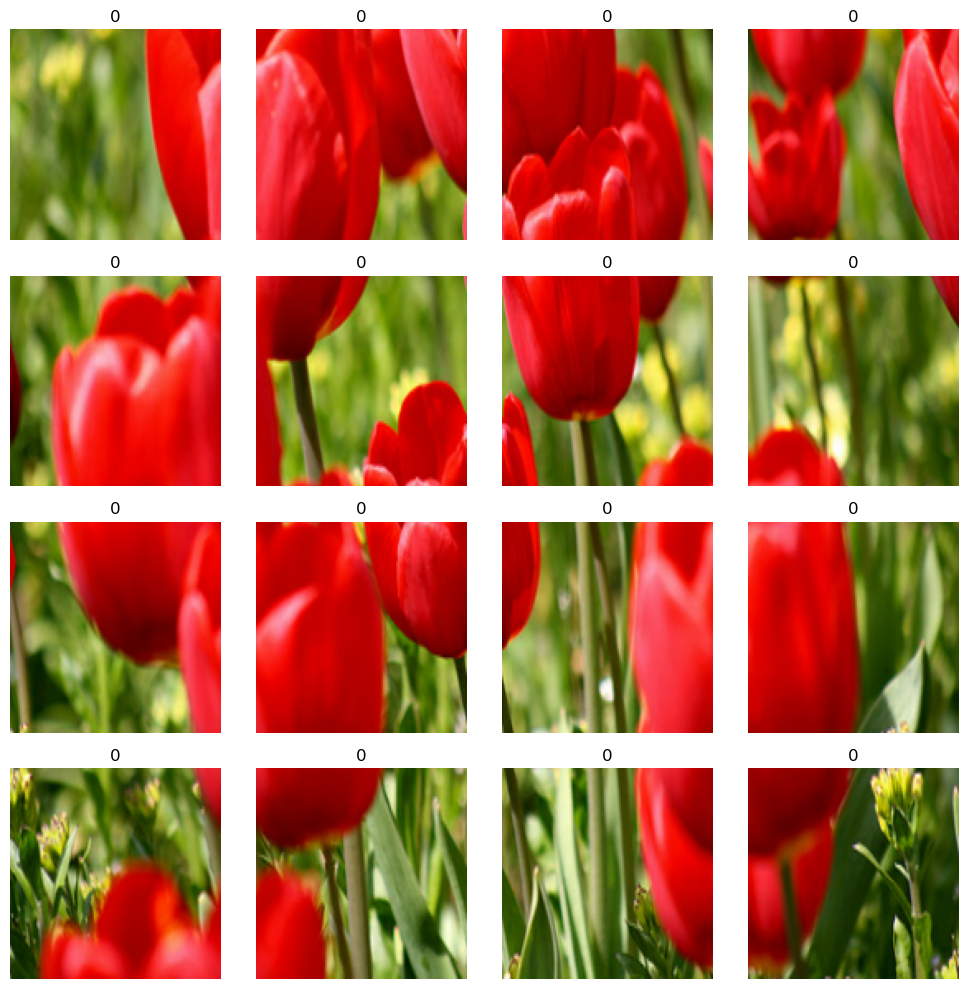

In [9]:
# Run Predictions on Tiles

predictions = model.predict(tiles_ds)
pred_labels = tf.argmax(predictions, axis=-1)
print("Predicted classes for each tile:", pred_labels.numpy())

# Visualize Tiled Predictions

num_tiles = tiles.shape[0]
cols = int(np.sqrt(num_tiles))
rows = int(np.ceil(num_tiles / cols))

plt.figure(figsize=(10, 10))
for i in range(num_tiles):
    plt.subplot(rows, cols, i+1)
    plt.imshow(tf.cast(tiles[i], tf.uint8))
    plt.title(int(pred_labels[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()


## Discussion
- When is tiling necessary?
- How does this relate to satellite imagery?
- How would we aggregate patch predictions?